In [29]:
# -*- coding: utf-8 -*-
"""
Created on Apr  5 11:11:08 2019

@author: timpara
"""

import quandl
import pandas as pd
import numpy as np
from scipy.special import ndtri
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

# Setup

In [30]:
tickers={"power":"CHRIS/ICE_DPB1","coal":"CHRIS/ICE_ATW1","carbon":"CHRIS/ICE_C1","eu":"CHRIS/CME_EC1"}
alpha=0.05
quandl_api_key=os.environ.get('QUANDLAPIKEY')
#power: euro
#coal: usd per ton
# I think carbon emmission certificates ECX EUA Futures, are listed as CHRIS/ICE_C1
positions=[-100,55,90]

## Helper functions

In [31]:
def dN(x, mu, sigma):
    ''' Probability density function of a normal random variable x.

    Parameters
    ==========
    mu : float
        expected value
    sigma : float
        standard deviation

    Returns
    =======
    pdf : float
        value of probability density function
    '''
    z = (x - mu) / sigma
    pdf = np.exp(-0.5 * z ** 2) / np.sqrt(2 * np.pi * sigma ** 2)
    return pdf

def quotes_returns(data):
    ''' Plots Cumulative and daily PnL. '''
    plt.figure(figsize=(9, 6))
    plt.subplot(211)
    data.cumsum().plot()
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.axis('tight')

    plt.subplot(212)
    data.plot()
    plt.ylabel('Daily PnL')
    plt.grid(True)
    plt.axis('tight')
    plt.savefig('quotes_returns.pdf')
# histogram of annualized daily log returns


def return_histogram(data):
    ''' Plots a histogram of the PnL. '''
    plt.figure(figsize=(9, 5))
    x = np.linspace(min(data), max(data), 100)
    plt.hist(np.array(data), bins=50, normed=True)
    y = dN(x, np.mean(data), np.std(data))
    plt.plot(x, y, linewidth=2)
    plt.xlabel('PnL')
    plt.ylabel('frequency/probability')
    plt.grid(True)
    plt.savefig('return_histogram.pdf')

# Q-Q plot of annualized daily log returns


def return_qqplot(data):
    ''' Generates a Q-Q plot of the returns.'''
    plt.figure(figsize=(9, 5))
    sm.qqplot(data, line='s')
    plt.grid(True)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')
    plt.savefig("return_qq_plot.pdf")
def print_statistics(data):
    print("RETURN SAMPLE STATISTICS")
    print("---------------------------------------------")
    print("Mean of Daily  Log Returns %9.6f" % np.mean(data))
    print("Mean of Annua. Log Returns %9.6f" %
          (np.mean(data) * 252))
    print("Std  of Annua. Log Returns %9.6f" %
          (np.std(data) * np.sqrt(252)))
    print("---------------------------------------------")
    print("Skew of Sample Log Returns %9.6f" % scs.skew(data))
    print("Skew Normal Test p-value   %9.6f" %
          scs.skewtest(data)[1])
    print("---------------------------------------------")
    print("Kurt of Sample Log Returns %9.6f" % scs.kurtosis(data))
    print("Kurt Normal Test p-value   %9.6f" %
          scs.kurtosistest(data)[1])
    print("---------------------------------------------")
    print("Normal Test p-value        %9.6f" %
          scs.normaltest(data)[1])
    print("---------------------------------------------")


## Main functions

In [40]:
def getData(tickers,quandl_api_key):
    '''
    Download data from quandl. Converte USD/Coal to Euro/Coal if Coal and Eu are given as ticker.
    
    Input:
    tickers: dictionary, Quandl tickers
    
    Output:
    data: levels, float
    returns: log returns based on settle price
    '''
    data=pd.DataFrame()
    for key,value in tickers.items():
        data[str(key+"_settle")]=quandl.get(value,start_date="2018-01-01",api_key=quandl_api_key)["Settle"]
    if "coal" and "eu" in tickers.keys():
        data["coal_settle"]=data["coal_settle"]*data["eu_settle"]
        data.drop(columns="eu_settle",inplace=True)
    #data["power_settle"]=data["power_settle"]*-1
    data.fillna(method='ffill', inplace=True)
    returns=np.log(data/data.shift(1)).dropna()
    max_record=len(returns)
    
    return data, returns,max_record
    
    #data_quandl.drop(columns=["eu_settle"],inplace=True)
def getPortfolioStatistics(returns,data,positions):
    portfolio={}
    portfolio["capital_per_position"]=np.array([data.power_settle[0]*positions[0],
                                data.coal_settle[0]*positions[1],
                               data.carbon_settle[0]*positions[2]])
    #total euro exposure
    portfolio["capital_total"]=np.sum(portfolio["capital_per_position"])
    
    #weights
    weights=portfolio["capital_per_position"]/np.sum(np.abs(portfolio["capital_per_position"]))
    #covariance matrix
    cov_mat_assets=np.cov(returns,rowvar=False)
    #volatility assets
    vol_assets=np.sqrt(np.diag(cov_mat_assets))
    #portfolio return
    ret_port=returns*portfolio["capital_per_position"]


    #portfolio cova
    cov_port=np.matmul(cov_mat_assets,weights)
    portfolio["pnl"]=ret_port
    #portfolio volatility
    portfolio["vol_port_euro"] = np.sqrt(np.matmul(portfolio["capital_per_position"].T,np.matmul(cov_mat_assets,portfolio["capital_per_position"])))
    portfolio["vol_port"] = np.sqrt(np.matmul(weights.T,np.matmul(cov_mat_assets,weights)))
    return portfolio,weights,cov_mat_assets,ret_port,cov_port,vol_assets

# Weighted Historical Simulation Approach. Defualt Significance Level is 95%
def hist_simul(return_pad, positions, max_record, eta=.99, signi=95):
    # Calculate Historical Daily Profits of Given Positions
    hist_profit = return_pad * positions
    hist_profit['total'] = hist_profit.apply(lambda x: x.sum(), axis=1)
    # Calculate Weights of Different Dates
    hist_weights = list(map(lambda x: eta ** (max_record - x - 1) * (1 - eta) / (1 - eta ** max_record),
                            [x for x in range(max_record)]))
    weighted_hist = np.column_stack((hist_profit.total.tolist(), hist_weights))
    # Sort Profits (Low to High)
    arg = np.argsort(weighted_hist[:, 0])
    weighted_hist = weighted_hist[arg]
    # Calculate Cumulative Weights
    cum_weights = np.cumsum(weighted_hist[:, 1], axis=0)
    weighted_hist = np.column_stack((weighted_hist, cum_weights))
    # Find Profits Around Significance Level
    arg = cum_weights <= (1 - signi / 100)
    arg2 = cum_weights >= (1 - signi / 100)
    # Interpolation
    ip_mat = np.row_stack((weighted_hist[arg][-1, [0, 2]], weighted_hist[arg2][0, [0, 2]]))
    hs_var = (ip_mat[1, 0] - ip_mat[0, 0]) / (ip_mat[1, 1] - ip_mat[0, 1]) * ((1 - signi / 100) - ip_mat[0, 1]) + ip_mat[0, 0]
    return hs_var


# Naive Historical Simulation Approach. Defualt Significance Level is 95%
def naive_hist(return_pad, positions, signi=95):
    hist_profit = return_pad * positions
    hist_total = hist_profit.sum(axis=1)
    nh_var = np.percentile(hist_total, 100 - signi)
    return nh_var


# Weighted Delta-Normal Simulation W or W/O RiskMetrics. Default Significance Level is 95%
def delta_norm(return_pad, positions, max_record, lmbd=.94, signi=95, rm_sign=1):
    # Employ RiskMetrics Weights
    dn_weights = list(map(lambda x: (1 - lmbd) * lmbd ** (max_record - x - 1), [x for x in range(max_record)]))
    if not rm_sign:
        dn_weights = 1 / max_record * np.ones(max_record)
    # Calculate Weighted/Unweighted COV, Assuming Zero-Mean
    weighted_cov = np.dot(return_pad.T * dn_weights, return_pad)
    delta = np.sqrt(np.dot(np.dot(positions, weighted_cov), positions))
    dn_var = delta * ndtri(1 - signi / 100)
    return dn_var


# Monte Carlo Approach. Default Significance Level is 95%
def monte_carlo(return_pad, positions, max_record, signi=95, iters=100000, lmbd=.94, rm_sign=1):
    # Calculate COV
    cov = return_pad.cov()
    if rm_sign:
        # Employ RiskMetrics Weights
        mc_weights = list(map(lambda x: (1 - lmbd) * lmbd ** (max_record - x - 1), [x for x in range(max_record)]))
        cov = np.dot(return_pad.T * mc_weights, return_pad)
    # Generate Simulated returns
    mc_simul = np.random.multivariate_normal(np.zeros(return_pad.shape[1]), cov, iters)
    simulated_profit = mc_simul * positions
    simulated_total = simulated_profit.sum(axis=1)
    mc_var = np.percentile(simulated_total, 100 - signi)
    return mc_var
def variance_covariance_decomp(portfolio,weights,cov_mat_assets,ret_port,cov_port,vol_assets):
    #Calculate the var in euro and percent
    VaR_port_euro=scs.norm.ppf(1-alpha)*portfolio["vol_port_euro"]
    VaR_port=scs.norm.ppf(1-alpha)*portfolio["vol_port"]

    #VaR per asset
    VaRi=scs.norm.ppf(1-alpha)*vol_assets*portfolio["capital_per_position"]
    # undiversified VaR as the sum of the VaRs of the individual assets.
    uVar = np.sum(VaRi)
    #beta of portfolio
    #beta = np.divide(cov_mat_assets,np.square(portfolio["vol_port"]))

    # Calculate Marginal VaR
    mVaR = scs.norm.ppf(1-alpha)*np.dot(cov_mat_assets,portfolio["capital_per_position"])/portfolio["vol_port_euro"]
    mVaR_euro=mVaR * portfolio["capital_per_position"]
    # component var
    cVaR = 100*mVaR * portfolio["capital_per_position"]/VaR_port_euro
    return cVaR,VaR_port_euro,mVaR_euro


## Run script

In [33]:
data, returns,max_record=getData(tickers)
portfolio,weights,cov_mat_assets,ret_port,cov_port,vol_assets=getPortfolioStatistics(returns,data,positions)



/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns -8.079405
Mean of Annua. Log Returns -2036.010040
Std  of Annua. Log Returns 1915.693942
---------------------------------------------
Skew of Sample Log Returns -0.520068
Skew Normal Test p-value    0.000217
---------------------------------------------
Kurt of Sample Log Returns  5.566667
Kurt Normal Test p-value    0.000000
---------------------------------------------
Normal Test p-value         0.000000
---------------------------------------------


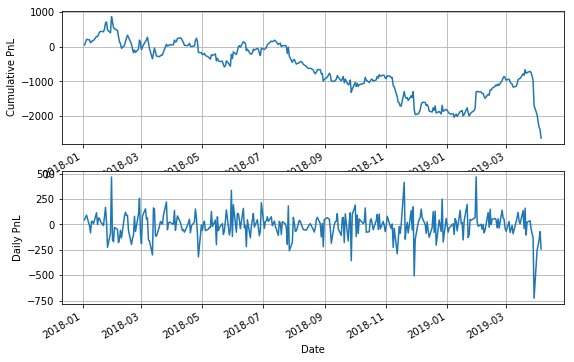

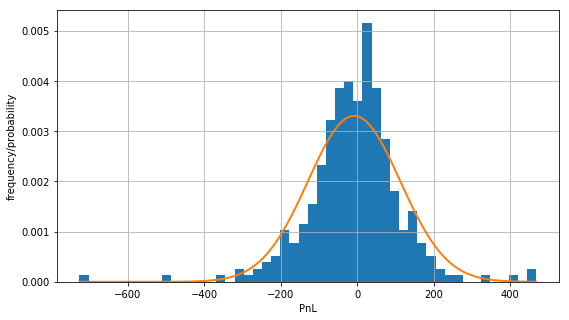

<Figure size 648x360 with 0 Axes>

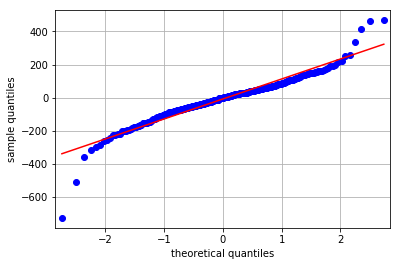

In [41]:
#insert graphical staff here and some descriptive analysis
quotes_returns(portfolio["pnl"])
return_histogram(portfolio["pnl"])
return_qqplot(portfolio["pnl"])
print_statistics(portfolio["pnl"])

In [35]:
-np.quantile(portfolio["pnl"],0.05)

196.97995391665296

In [36]:
cVaR,VaR_port_euro,mVaR_euro=variance_covariance_decomp(portfolio,weights,cov_mat_assets,ret_port,cov_port,vol_assets)


In [38]:
print("Portfolio VaR and decomposed VaR")
print("---------------------------------------------")
print("Daily VaR using Variance-Covariance Method %9.2f Euro" % np.round(VaR_port_euro,2)) 
print("1-Day VaR confidence level alpha %9.2f" %alpha)
print(" Component VaR:")
k=0
for i in tickers.keys():
    print("Asset: {} iVaR: {} and {} %".format(i,np.round(mVaR_euro[k],2),np.round(cVaR[k],2)))
    k+=1
    if k==3:
        break
        
        

Portfolio VaR and decomposed VaR
---------------------------------------------
Daily VaR using Variance-Covariance Method    198.80 Euro
1-Day VaR confidence level alpha      0.05
 Component VaR:
Asset: power iVaR: 133.85 and 67.33 %
Asset: coal iVaR: 67.1 and 33.75 %
Asset: carbon iVaR: -2.15 and -1.08 %


In [37]:
portfolio["capital_per_position"]

array([-4810.     ,  6435.24695,   700.2    ])

In [39]:
print("Benchmark Variance-Covariance method:")

hs_var = -hist_simul(returns, portfolio["capital_per_position"], max_record)
dn_var = -delta_norm(returns, portfolio["capital_per_position"], max_record)
mc_var = -monte_carlo(returns, portfolio["capital_per_position"], max_record)
print('Tomorrow VaR for the portfolio is Euro', round(hs_var, 2), 'using historical simulation method (RiskMetrics weighting).')
print('Tomorrow VaR for the portfolio is Euro', round(dn_var, 2), 'using delta-normal method (RiskMetrics weighting).')
print('Tomorrow VaR for the portfolio is Euro', round(mc_var, 2), 'using Monte Carlo method.')

Benchmark Variance-Covariance method:
Tomorrow VaR for the portfolio is $ 221.03 using historical simulation method.
Tomorrow VaR for the portfolio is $ 324.25 using delta-normal method.
Tomorrow VaR for the portfolio is $ 326.76 using Monte Carlo method.


In [42]:
portfolio["capital_per_position"]

array([-4810.     ,  6435.24695,   700.2    ])